In [2]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.patches as patches
% matplotlib inline

In [3]:
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y*2008*.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))
ptrc=nc.Dataset(nc_filename[0])

uvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridU_19692008.nc')
print uvel.variables

vvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridV_19692008.nc')
print vvel.variables

wvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridW_19692008.nc')
print wvel.variables

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y19682008.nc']
OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7f2c10901050>), (u'nav_lat', <netCDF4.Variable object at 0x7f2c109010e8>), (u'depthu', <netCDF4.Variable object at 0x7f2c10901180>), (u'time_counter', <netCDF4.Variable object at 0x7f2c10901218>), (u'vozocrtx', <netCDF4.Variable object at 0x7f2c109012b0>), (u'sozotaux', <netCDF4.Variable object at 0x7f2c10901348>)])
OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7f2c10901478>), (u'nav_lat', <netCDF4.Variable object at 0x7f2c10901510>), (u'depthv', <netCDF4.Variable object at 0x7f2c109015a8>), (u'time_counter', <netCDF4.Variable object at 0x7f2c10901640>), (u'vomecrty', <netCDF4.Variable object at 0x7f2c109016d8>), (u'sometauy', <netCDF4.Variable object at 0x7f2c10901770>)])
OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7f2c109018a0>), (u'nav_lat', <netCDF4.Variable object at 0x7f2c10901938>), (u'depthw', <netCDF4.Variable o

In [4]:
lon=ptrc.variables['nav_lon'][:,:]
lat=ptrc.variables['nav_lat'][:,:]
dep = ptrc.variables['deptht'][:]


tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy=tmask.variables['mbathy'][0,400:,:]
tmask=tmask.variables['tmask'][0,:,400:,:]


bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

In [5]:
yearnum=len(ptrc.variables['TR_7'][:,0,0,0])

In [6]:
def vel(keyword,time):
    'design to obtain velocity field'
    if keyword =='U':
        data =uvel.variables['vozocrtx'][time,:,400:,:]
    elif keyword =='V':
        data =vvel.variables['vomecrty'][time,:,400:,:]
    else:
        data =wvel.variables['vovecrtz'][time,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

In [72]:
def test(u0,v0):
    layer=38
    k=0
    lon=ptrc.variables['nav_lon'][:,:]
    lat=ptrc.variables['nav_lat'][:,:]
    fig = plt.figure(figsize=(18,45))
    for i in range (0,yearnum,1):
        time =i
        k+=1

        ax = fig.add_subplot(10,4,5)
        m = Basemap(projection='npstere',boundinglat=70,lon_0=0+i*90,resolution='l')
        m.drawcoastlines()
        m.fillcontinents(color = '0.75')
        m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x_lon,y_lat = m(lon,lat)
        u =vel('U',time)
        v =vel('V',time)
        #mask too large value
        u =np.ma.masked_where(abs(v)>0.03,u)
        #u[:] = u0
        v =np.ma.masked_where(abs(v)>0.03,v)
        #v[:] = v0
        uu = np.zeros((u.shape))
        u  = u-uu

        u, v, x, y = m.rotate_vector(u[layer,:,:], v[layer,:,:], lon[:,:], lat[:,:], returnxy=True)
        Q=m.quiver(x[::25,::25], y[::25,::25], u[::25,::25], v[::25,::25],
                   width=0.01,pivot='middle')
        Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.02, '0.02 m/s',fontproperties={'weight': 'bold'}) #x(0-1),y(0-1), scale, label, position

        m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.4)

        plt.title('w, %sm, time: %s'%(dep[layer],2007+i))

    plt.show()

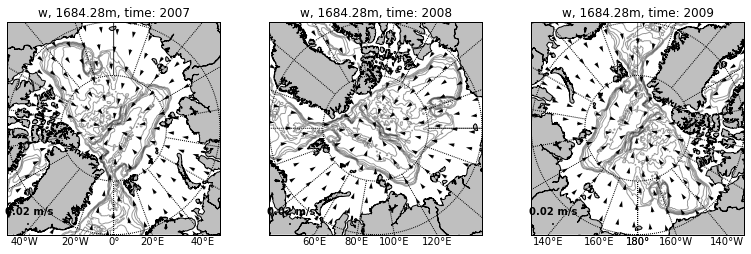

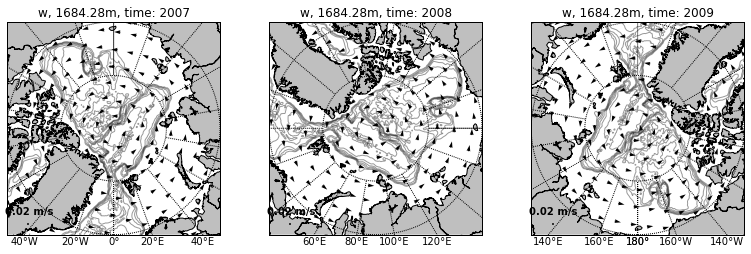

In [73]:
test(u0=0,v0=1)#all to north
test(u0=1,v0=0)#all to east

In [45]:
def velfield(lon_0):
    layer=38
    k=0
    lon=ptrc.variables['nav_lon'][:,:]
    lat=ptrc.variables['nav_lat'][:,:]
    fig = plt.figure(figsize=(18,45))
    for i in range (yearnum):
        time =i
        k+=1

        ax = fig.add_subplot(1,3,k)
        m = Basemap(projection='npstere',boundinglat=70,lon_0=lon_0,resolution='l')
        m.drawcoastlines()
        m.fillcontinents(color = '0.75')
        m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x_lon,y_lat = m(lon,lat)
        u =vel('U',time)
        v =vel('V',time)
        #mask too large value
        u =np.ma.masked_where(abs(v)>0.03,u)
        v =np.ma.masked_where(abs(v)>0.03,v)
        Q=m.quiver(x_lon[::20,::20], y_lat[::20,::20], u[layer,::20,::20], v[layer,::20,::20],
                   width=0.015)
        uu = np.zeros((u.shape))
        u  = u-uu

        u, v, x, y = m.rotate_vector(u[layer,:,:], v[layer,:,:], lon[:,:], lat[:,:], returnxy=True)
        Q=m.quiver(x[::20,::20], y[::20,::20], u[::20,::20], v[::20,::20],
                   width=0.015,color='red')

        Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.02, '0.02 m/s ',fontproperties={'weight': 'bold'}) #x(0-1),y(0-1), scale, label, position

        m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.4)

        plt.title('w, %sm, time: %s'%(dep[layer],2007+i))

    plt.show()

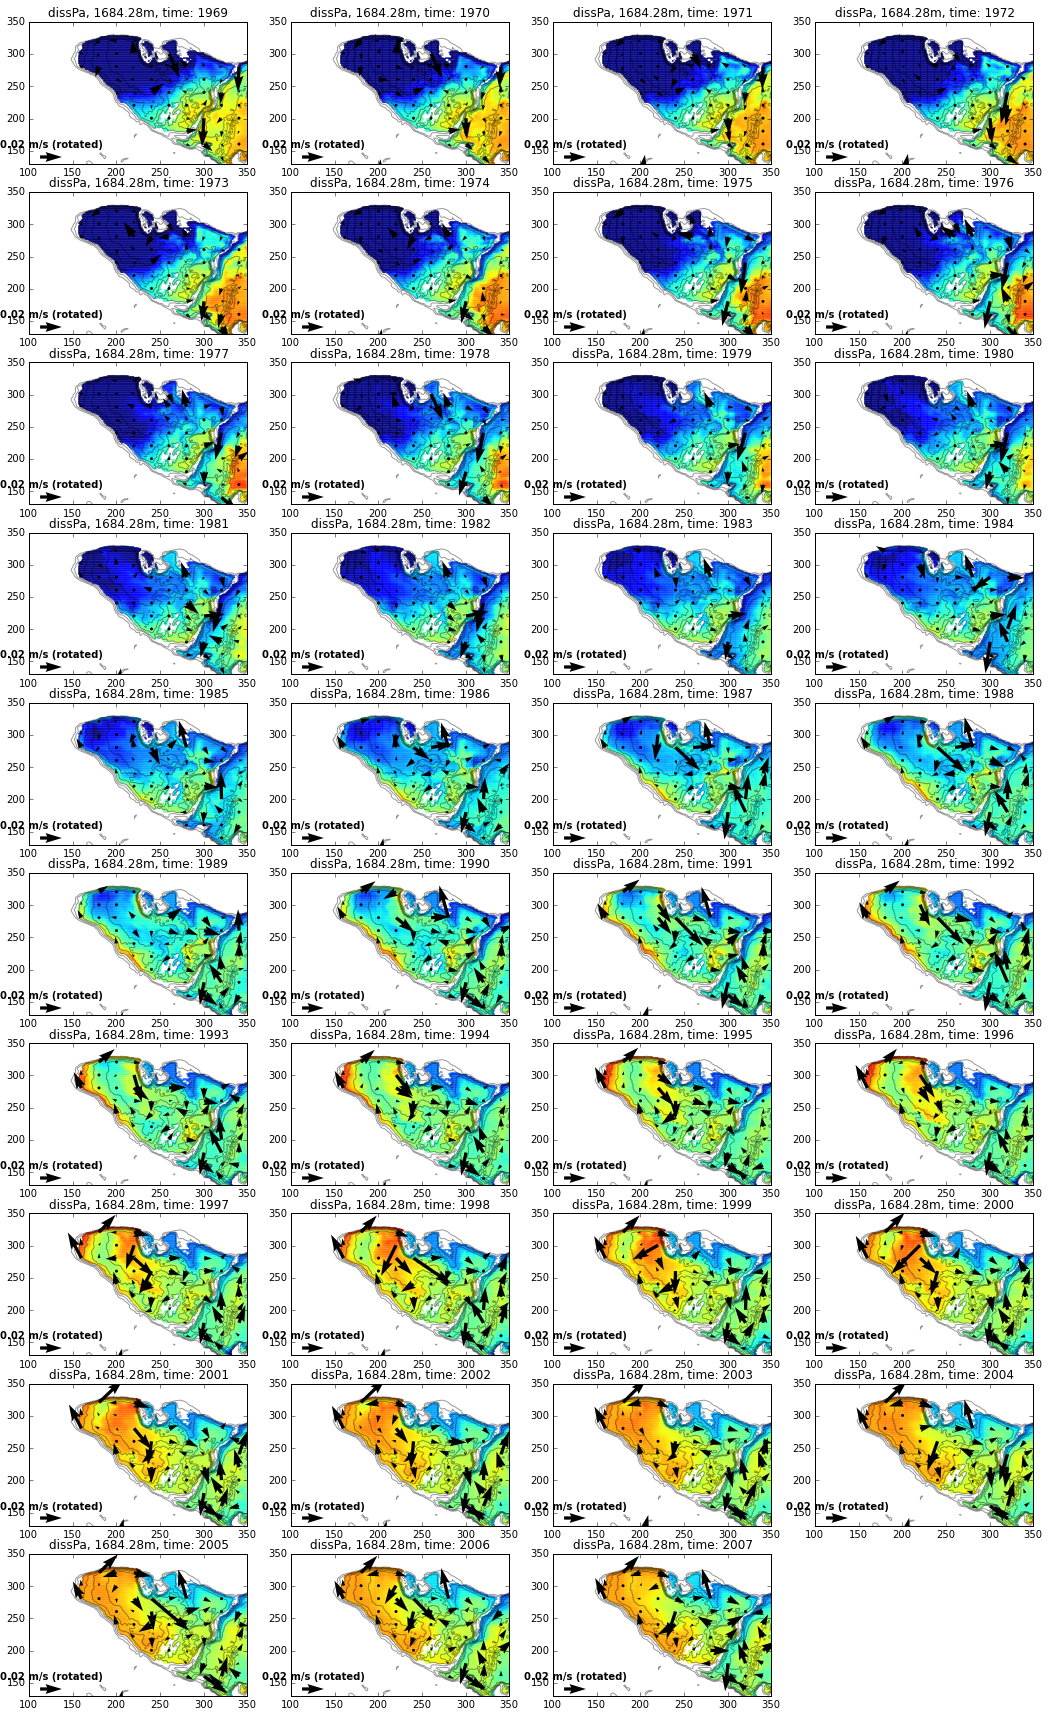

In [28]:
layer=38
k=0
lon=ptrc.variables['nav_lon'][:,:]
lat=ptrc.variables['nav_lat'][:,:]
x1d=np.linspace(0,lon[:,0].shape[0],lon[:,0].shape[0])
y1d=np.linspace(0,lon[0,:].shape[0],lon[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)


fig = plt.figure(figsize=(18,30))
for i in range (0,yearnum,1):
    time =i
    k+=1
    time =i
    data =ptrc.variables['TR_7'][time,:,:,:]
    data =np.ma.masked_where(tmask==0,data)
    
    ax = fig.add_subplot(10,4,k)
    plt.pcolor(x2d[:,:], y2d[:,:], data[layer,:,:],alpha=0.4,vmin=0.2,vmax=0.3)
    
    x_lon,y_lat = lon,lat
    u =vel('U',time)
    v =vel('V',time)
    #mask too large value
    u =np.ma.masked_where(abs(v)>0.03,u)
    v =np.ma.masked_where(abs(v)>0.03,v)
    Q=plt.quiver(x2d[::20,::20], y2d[::20,::20], u[layer,::20,::20], v[layer,::20,::20],scale=0.2,
               width=0.015)
    uu = np.zeros((u.shape))
    u  = u-uu


    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.02, '0.02 m/s ',fontproperties={'weight': 'bold'}) #x(0-1),y(0-1), scale, label, position

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
        

    plt.title('dissPa, %sm, time: %s'%(dep[layer],1969+i))
    plt.ylim(130,350)    
    plt.xlim(100,350)
plt.show()

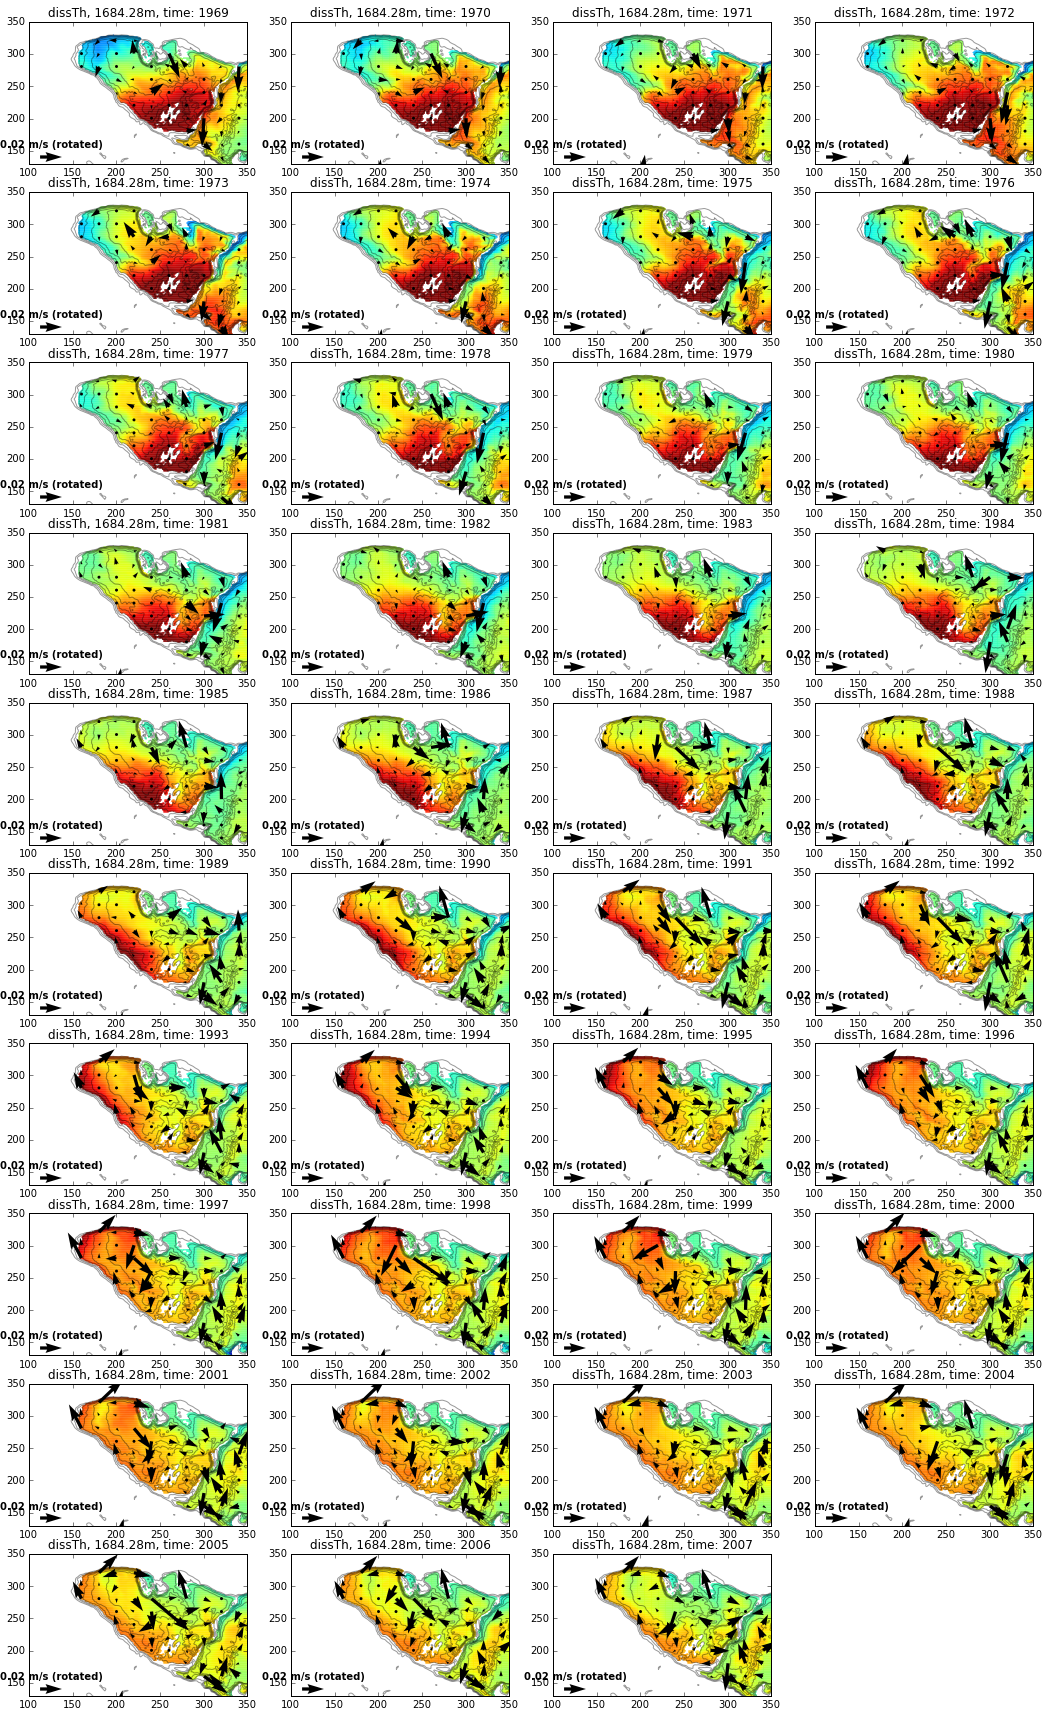

In [30]:
k=0
fig = plt.figure(figsize=(18,30))
for i in range (0,yearnum,1):
    time =i
    k+=1
    time =i
    data =ptrc.variables['TR_8'][time,:,:,:]
    data =np.ma.masked_where(tmask==0,data)
    
    ax = fig.add_subplot(10,4,k)
    plt.pcolor(x2d[:,:], y2d[:,:], data[layer,:,:],alpha=0.4,vmin=0.25,vmax=0.75)
    
    x_lon,y_lat = lon,lat
    u =vel('U',time)
    v =vel('V',time)
    #mask too large value
    u =np.ma.masked_where(abs(v)>0.03,u)
    v =np.ma.masked_where(abs(v)>0.03,v)
    Q=plt.quiver(x2d[::20,::20], y2d[::20,::20], u[layer,::20,::20], v[layer,::20,::20],scale=0.2,
               width=0.015)
    uu = np.zeros((u.shape))
    u  = u-uu


    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.02, '0.02 m/s ',fontproperties={'weight': 'bold'}) #x(0-1),y(0-1), scale, label, position

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
        

    plt.title('dissTh, %sm, time: %s'%(dep[layer],1969+i))
    plt.ylim(130,350)    
    plt.xlim(100,350)
plt.show()

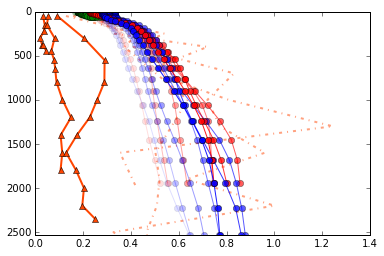

In [76]:
import pandas as pd
obs_filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/total/T*.csv'))

for j in range(len(obs_filename)):
    data=pd.read_csv(obs_filename[j])
    y= data['depth'].values;
    x=data['230Th tot.'].values;
    lon = data['long.'].values;
    lat = data['lat.'].values;
    #name= data['name'][0];
    y_=[];x_=[];lon_=[];lat_=[];
    for i in range (len(x)):
        if x[i]>=0:
            y_.append(y[i]);x_.append(x[i])
            lon_.append(lon[i]);lat_.append(lat[i])
    if j<3 and len(lon_)!=0:
        if j ==0:
            plt.plot(x_,y_,'-^',lw=2,c='orangered',label='data(2007)')
        else:
            plt.plot(x_,y_,'-^',lw=2,c='orangered')#,label='data(2007)')
    if j>=3 and len(lon_)!=0:
        if j==3:
            plt.plot(x_,y_,'-.',lw=2,c='orangered',label='data(2009)',alpha=0.5) 
        else:
            plt.plot(x_,y_,'-.',lw=2,c='orangered',alpha=0.5)#,label='data(2009)') 

for i in range (0,yearnum,5):
    time =np.float(i)
    data =ptrc.variables['TR_8'][i,:,:,:]+ptrc.variables['TR_10'][i,:,:,:]
    data =np.ma.masked_where(tmask==0,data)
    plt.plot(data[:,303,150],dep[:],'o-',color='g',alpha=time/yearnum)
    plt.plot(data[:,302,160],dep[:],'o-',color='r',alpha=time/yearnum)
    plt.plot(data[:,300,170],dep[:],'o-',color='b',alpha=time/yearnum)

plt.ylim(0,2530)    
plt.gca().invert_yaxis()

/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


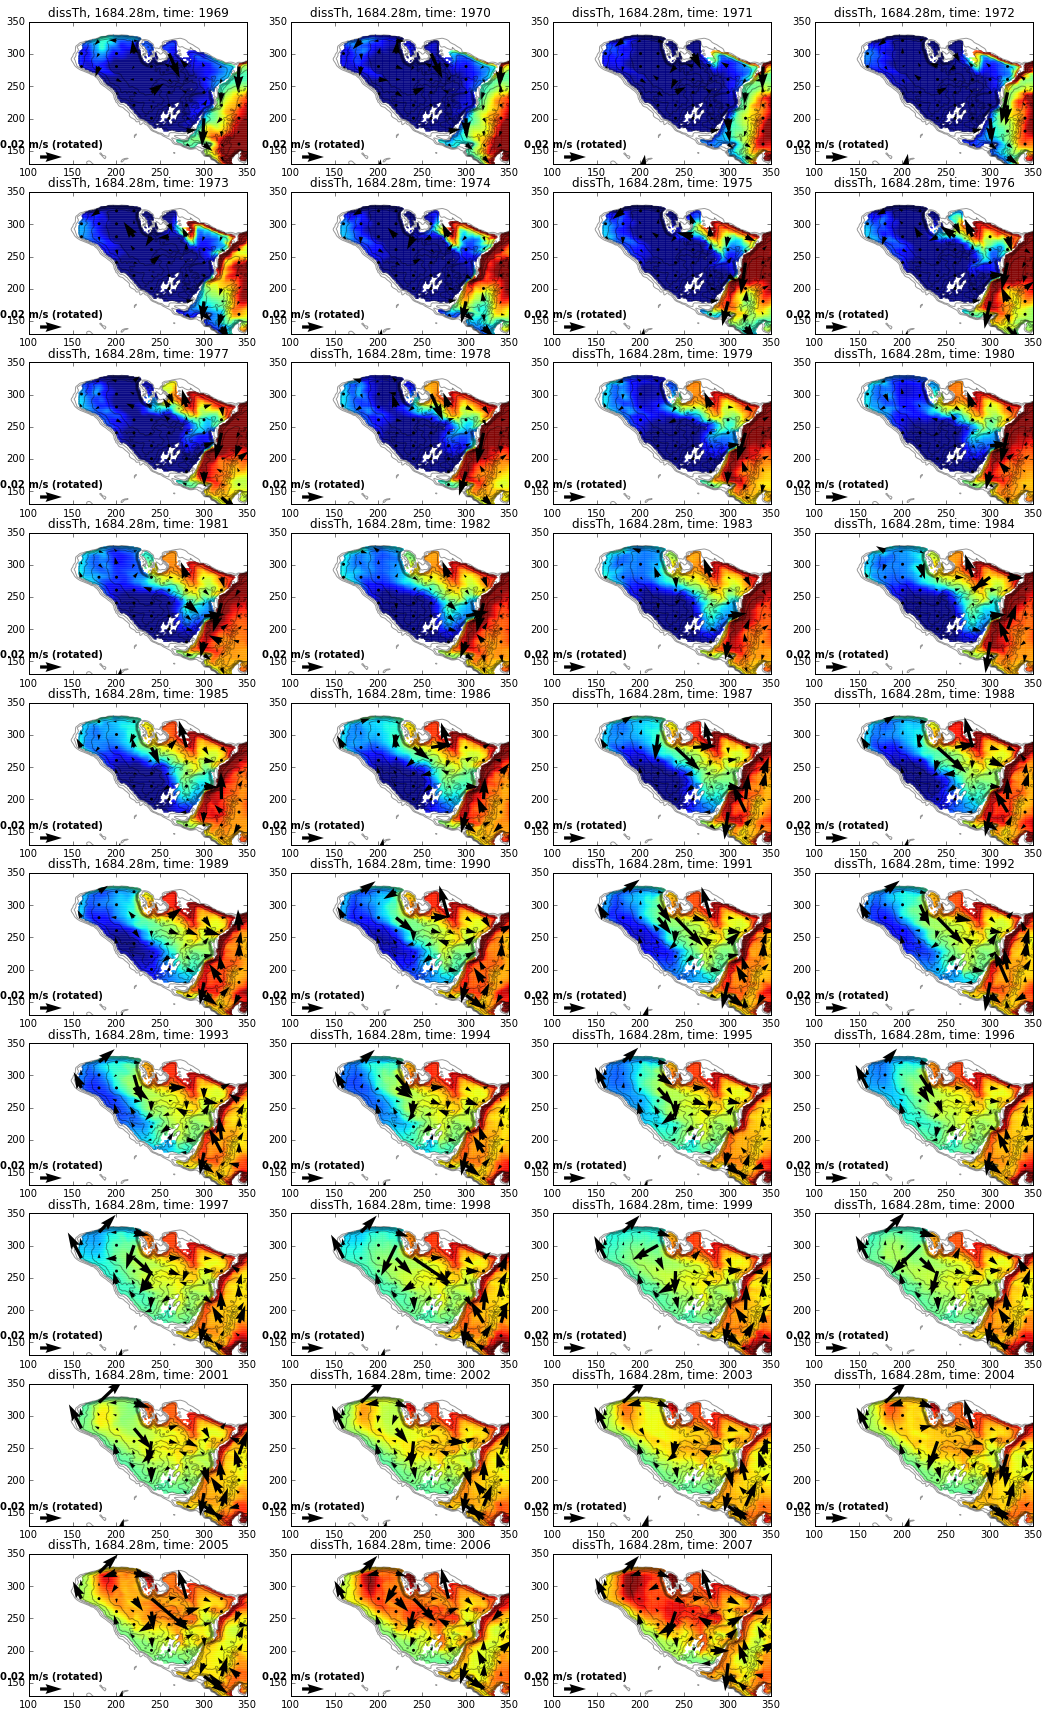

In [31]:
k=0
fig = plt.figure(figsize=(18,30))
for i in range (0,yearnum,1):
    time =i
    k+=1
    time =i
    data =ptrc.variables['TR_7'][time,:,:,:]/ptrc.variables['TR_8'][time,:,:,:]
    data =np.ma.masked_where(tmask==0,data)
    
    ax = fig.add_subplot(10,4,k)
    plt.pcolor(x2d[:,:], y2d[:,:], data[layer,:,:],alpha=0.4,vmin=0.35,vmax=0.50)
    
    x_lon,y_lat = lon,lat
    u =vel('U',time)
    v =vel('V',time)
    #mask too large value
    u =np.ma.masked_where(abs(v)>0.03,u)
    v =np.ma.masked_where(abs(v)>0.03,v)
    Q=plt.quiver(x2d[::20,::20], y2d[::20,::20], u[layer,::20,::20], v[layer,::20,::20],scale=0.2,
               width=0.015)
    uu = np.zeros((u.shape))
    u  = u-uu


    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.02, '0.02 m/s ',fontproperties={'weight': 'bold'}) #x(0-1),y(0-1), scale, label, position

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
        

    plt.title('dissTh, %sm, time: %s'%(dep[layer],1969+i))
    plt.ylim(130,350)    
    plt.xlim(100,350)
plt.show()